In [1]:
! pip install torch  torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
! pip install langchain chromadb sentence-transformers  faiss-cpu torchdata==0.11.0 langchain-community

In [4]:
! pip install git+https://github.com/facebookresearch/audiocraft.git

  Cloning https://github.com/facebookresearch/audiocraft.git to c:\users\asus\appdata\local\temp\pip-req-build-2ket5ogw
  Resolved https://github.com/facebookresearch/audiocraft.git to commit 896ec7c47f5e5d1e5aa1e4b260c4405328bf009d
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torchvision-0.16.0-cp39-cp39-win_amd64.whl.metadata (6.6 kB)
Using cached torchvision-0.16.0-cp39-cp39-win_amd64.whl (1.3 MB)


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/audiocraft.git 'C:\Users\Asus\AppData\Local\Temp\pip-req-build-2ket5ogw'


In [3]:
from audiocraft.models import MusicGen
from langchain_community.embeddings import SentenceTransformerEmbeddings  
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import RetrievalQA
import torchaudio
import torch
from langchain.llms.fake import FakeListLLM
from langchain_community.vectorstores import Chroma

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.0+cu118)
    Python  3.9.13 (you have 3.9.23)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
d:\trygpu\lasttry\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
docs = TextLoader("mood.txt").load()
docs = CharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)




 

In [31]:
embed = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
vectordb = Chroma.from_documents(docs, embed, persist_directory="./chroma_db")
retriever = vectordb.as_retriever()

In [32]:


fake_llm = FakeListLLM(responses=[""]) 
qa_chain = RetrievalQA.from_chain_type(
    llm=fake_llm,
    retriever=retriever,
    return_source_documents=False
)


In [33]:
# Use GPU if available for faster generation
device = "cuda" if torch.cuda.is_available() else "cpu"
mg = MusicGen.get_pretrained("small")
mg.lm.to(device) 
mg.set_generation_params(duration=20)


d:\trygpu\lasttry\lib\site-packages\audiocraft\models\musicgen.py:83: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-small
  warnings.warn(
d:\trygpu\lasttry\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
def generate_track(mood_prompt: str, output_path: str = "output.wav"):
    context = qa_chain.run(mood_prompt)
    
    final_prompt = f"{mood_prompt}. Style notes: {context}"
    wav = mg.generate([final_prompt], progress=True)[0]

    # Make sure waveform is 2D (1, num_samples)
    if wav.dim() == 1:
        wav = wav.unsqueeze(0)
   
    torchaudio.save(output_path, wav.cpu(), sample_rate=mg.sample_rate)  
    

In [ ]:
from flask import Flask, request, render_template_string, send_file
app = Flask(__name__)

HTML_TEMPLATE = """
<!doctype html>
<html>
  <head>
    <title>Music Track Generator</title>
    <style>
      body {
        background-color: black;
        color: white;
        font-family: Arial;
        display: flex;
        justify-content: center;
        align-items: center;
        height: 100vh;
        flex-direction: column;
      }
      input[type=text] {
        width: 300px;
        padding: 10px;
        margin-top: 10px;
      }
      input[type=submit] {
        padding: 10px 20px;
        background-color: red;
        color: white;
        border: none;
        margin-top: 10px;
        cursor: pointer;
      }
      .error {
        color: yellow;
        margin-top: 10px;
      }
      .waiting {
        color: cyan;
        margin-top: 15px;
        font-style: italic;
        display: none;
      }
    </style>
    <script>
      function validateAndShowWait() {
        var input = document.querySelector("input[name='prompt']");
        var promptValue = input.value.trim();

        // Clear any existing error message if present
        const existingError = document.querySelector(".error");
        if (existingError) {
          existingError.innerText = "";
        }

        if (promptValue === "") {
          alert("Prompt cannot be empty. Please enter a music prompt.");
          input.focus();
          return false; // prevent form submission
        }

        document.getElementById("waitMessage").style.display = "block";
        return true; // allow form submission
      }
    </script>
  </head>
  <body>
    <h2>Enter Prompt for Track</h2>
    <form method="POST" onsubmit="return validateAndShowWait()">
      <input type="text" name="prompt" placeholder="e.g. late-night horror">
      <br>
      <input type="submit" value="Generate">
    </form>

    <div id="waitMessage" class="waiting">Please wait 30–40 seconds, track is generating...</div>

    {% if error %}
      <div class="error">{{ error }}</div>
    {% endif %}
    {% if filename %}
      <h3>Generated Track:</h3>
      <audio controls>
        <source src="{{ url_for('get_audio', filename=filename) }}" type="audio/wav">
        Your browser does not support the audio element.
      </audio>
    {% endif %}
  </body>
</html>
"""

@app.route("/", methods=["GET", "POST"])
def index():
    error = None
    filename = None
    if request.method == "POST":
        prompt = request.form.get("prompt", "").strip()
        if not prompt:
            error = "Prompt cannot be empty. Please enter a music prompt."
        else:
            filename = "music_track.wav"
            generate_track(prompt, filename)
    return render_template_string(HTML_TEMPLATE, error=error, filename=filename)

@app.route("/audio/<filename>")
def get_audio(filename):
    return send_file(filename, mimetype="audio/wav")

@app.route('/favicon.ico')
def favicon():
    # Prevents 404 for /favicon.ico
    return '', 204

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [25/Jun/2025 20:21:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Jun/2025 20:21:09] "GET /favicon.ico HTTP/1.1" 204 -
127.0.0.1 - - [25/Jun/2025 20:21:39] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Jun/2025 20:21:39] "GET /favicon.ico HTTP/1.1" 204 -


127.0.0.1 - - [25/Jun/2025 20:22:33] "POST / HTTP/1.1" 200 -


gpu
Saved 20s track to late_night_horror.wav


127.0.0.1 - - [25/Jun/2025 20:22:33] "GET /audio/late_night_horror.wav HTTP/1.1" 206 -
127.0.0.1 - - [25/Jun/2025 20:22:33] "GET /favicon.ico HTTP/1.1" 204 -
127.0.0.1 - - [25/Jun/2025 20:23:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Jun/2025 20:23:06] "GET /favicon.ico HTTP/1.1" 204 -


gpu003 /   1003


127.0.0.1 - - [25/Jun/2025 20:23:50] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [25/Jun/2025 20:23:50] "GET /audio/late_night_horror.wav HTTP/1.1" 206 -
127.0.0.1 - - [25/Jun/2025 20:23:50] "GET /audio/late_night_horror.wav HTTP/1.1" 206 -
127.0.0.1 - - [25/Jun/2025 20:23:51] "GET /favicon.ico HTTP/1.1" 204 -


Saved 20s track to late_night_horror.wav


127.0.0.1 - - [25/Jun/2025 20:23:53] "GET /favicon.ico HTTP/1.1" 204 -
127.0.0.1 - - [25/Jun/2025 20:23:53] "GET /audio/late_night_horror.wav HTTP/1.1" 206 -


In [ ]:
def generate_raw_track(prompt, path="soft_music.wav"):
    wav = mg.generate([prompt], progress=True)[0]
    if wav.dim() == 1:
        wav = wav.unsqueeze(0)
    torchaudio.save(path, wav.cpu(), sample_rate=mg.sample_rate)

def generate_styled_track(prompt, path="styled_prompt_music.wav"):
    context = qa_chain.run(prompt)
    full_prompt = f"{prompt}. Style notes: {context}"
    wav = mg.generate([full_prompt], progress=True)[0]
    if wav.dim() == 1:
        wav = wav.unsqueeze(0)
    torchaudio.save(path, wav.cpu(), sample_rate=mg.sample_rate)


In [45]:
generate_styled_track("soft drums")

In [ ]:
def generate_styled_track(prompt, path="hard_music.wav"):
    context = qa_chain.run(prompt)
    full_prompt = f"{prompt}. Style notes: {context}"
    wav = mg.generate([full_prompt], progress=True)[0]
    if wav.dim() == 1:
        wav = wav.unsqueeze(0)
    torchaudio.save(path, wav.cpu(), sample_rate=mg.sample_rate)

In [ ]:
generate_styled_track("hard drums")

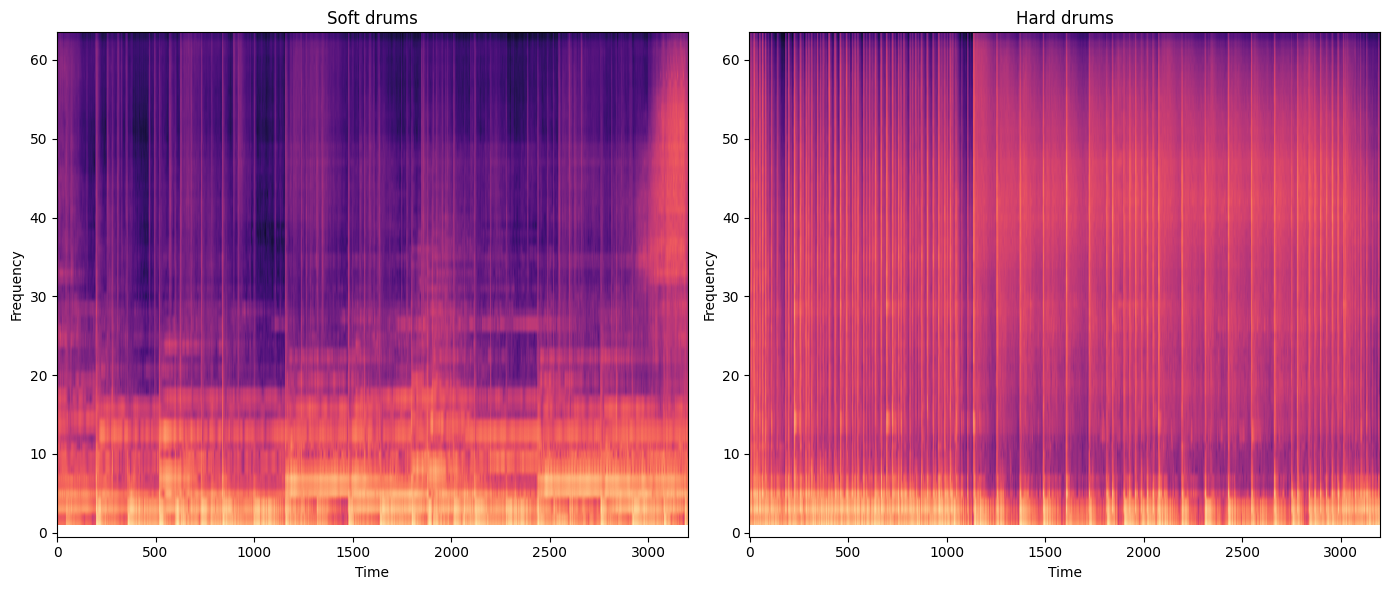

In [54]:
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T

def plot_spectrogram(wav_path, title, index):
    waveform, sample_rate = torchaudio.load(wav_path)
    spectrogram = T.MelSpectrogram(sample_rate=sample_rate, n_mels=64)(waveform)
    spec_db = spectrogram.log2()[0, :, :].detach().numpy()

    plt.subplot(1, 2, index)
    plt.imshow(spec_db, aspect='auto', origin='lower', cmap='magma')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')

plt.figure(figsize=(14, 6))
plot_spectrogram("soft_music.wav", "Soft drums", 1)
plot_spectrogram("hard_music.wav", "Hard drums", 2)
plt.tight_layout()
plt.savefig("spectrogram_comparison.png")
plt.show()
